In [ ]:
#Importing the libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
# !pip install pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)


In [ ]:
#Loading the dataset
data = pd.read_csv("bank_transactions_data_2.csv")


In [3]:
data.head()

TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX001313   AC00001              47.79  2023-09-15 17:00:20   
1      TX002017   AC00001             212.97  2023-11-14 16:56:34   
2      TX002121   AC00002             476.99  2023-01-10 16:00:32   
3      TX000021   AC00002              59.32  2023-02-28 16:36:58   
4      TX001477   AC00002              12.62  2023-05-05 16:35:44   

  TransactionType     Location DeviceID       IP Address MerchantID Channel  \
0           Debit       Denver  D000649      59.12.96.11       M034  Branch   
1           Debit      Atlanta  D000492    45.241.13.208       M003  Online   
2           Debit    San Diego  D000594  113.137.153.101       M022  Online   
3           Debit  Los Angeles  D000152    116.44.12.250       M040  Branch   
4           Debit      El Paso  D000475    93.160.83.196       M068  Branch   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           25            Student                   37              1   
1           59           Engineer                  178              1   
2           23            Student                  187              1   
3           71            Retired                   38              1   
4           33             Doctor                   61              1   

   AccountBalance PreviousTransactionDate  Fraudulent  
0         1649.92     2024-11-04 08:11:55           0  
1         4180.40     2024-11-04 08:10:42           0  
2         1154.48     2024-11-04 08:10:10           1  
3         5750.89     2024-11-04 08:09:24           1  
4         6420.47     2024-11-04 08:09:03           1

In [4]:
data.tail()

TransactionID AccountID  TransactionAmount      TransactionDate  \
2507      TX001943   AC00499             837.29  2023-11-27 16:14:25   
2508      TX002055   AC00500             156.86  2023-01-30 16:37:53   
2509      TX001716   AC00500             225.93  2023-03-13 17:57:47   
2510      TX002375   AC00500             129.62  2023-07-06 16:47:00   
2511      TX002350   AC00500             134.55  2023-10-09 16:44:50   

     TransactionType   Location DeviceID       IP Address MerchantID Channel  \
2507           Debit    Phoenix  D000189  217.233.219.196       M002  Branch   
2508           Debit  Charlotte  D000168   11.167.243.171       M099     ATM   
2509          Credit      Omaha  D000142   147.114.91.132       M097  Branch   
2510          Credit   San Jose  D000179     37.143.57.20       M070     ATM   
2511           Debit   San Jose  D000219   100.137.90.188       M026  Online   

      CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
2507           25            Student                  216              1   
2508           51             Doctor                  102              1   
2509           25            Student                  199              1   
2510           23            Student                  124              1   
2511           59             Doctor                  165              1   

      AccountBalance PreviousTransactionDate  Fraudulent  
2507         6012.67     2024-11-04 08:07:12           1  
2508        14453.35     2024-11-04 08:10:27           1  
2509         1864.27     2024-11-04 08:08:39           1  
2510          620.28     2024-11-04 08:06:51           1  
2511        14852.42     2024-11-04 08:08:25           1

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [ ]:
#Checking the missing values
data.isnull().sum()

TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
Fraudulent                 0
dtype: int64

In [ ]:
#Statistics summary,class distribution and shape of the dataset
print("Dataset Shape:", data.shape)
print("\nSummary Statistics:\n", data.describe(include='all'))
print("\nClass Distribution:\n", data['Fraudulent'].value_counts())


Dataset Shape: (2512, 17)

Summary Statistics:
        TransactionID AccountID  TransactionAmount      TransactionDate  \
count           2512      2512        2512.000000                 2512   
unique          2512       495                NaN                 2512   
top         TX001313   AC00202                NaN  2023-09-15 17:00:20   
freq               1        12                NaN                    1   
mean             NaN       NaN         297.593778                  NaN   
std              NaN       NaN         291.946243                  NaN   
min              NaN       NaN           0.260000                  NaN   
25%              NaN       NaN          81.885000                  NaN   
50%              NaN       NaN         211.140000                  NaN   
75%              NaN       NaN         414.527500                  NaN   
max              NaN       NaN        1919.110000                  NaN   

       TransactionType    Location DeviceID      IP Address Mer

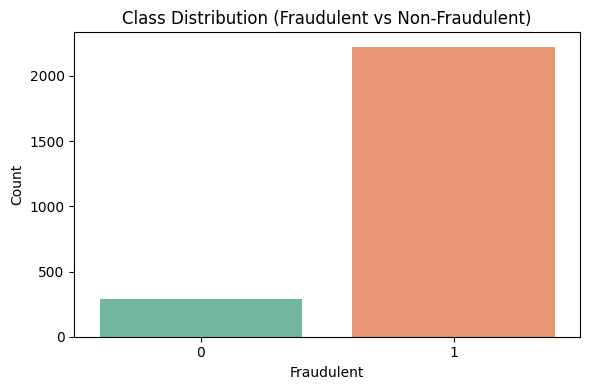

In [ ]:
#EXPLORATORY DATA ANALYSIS(EDA)
# Distribution of Fraudulent vs Non-Fraudulent Transactions
plt.figure(figsize=(6, 4))
sns.countplot(x='Fraudulent', data=data, palette='Set2')
plt.title('Class Distribution (Fraudulent vs Non-Fraudulent)')
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


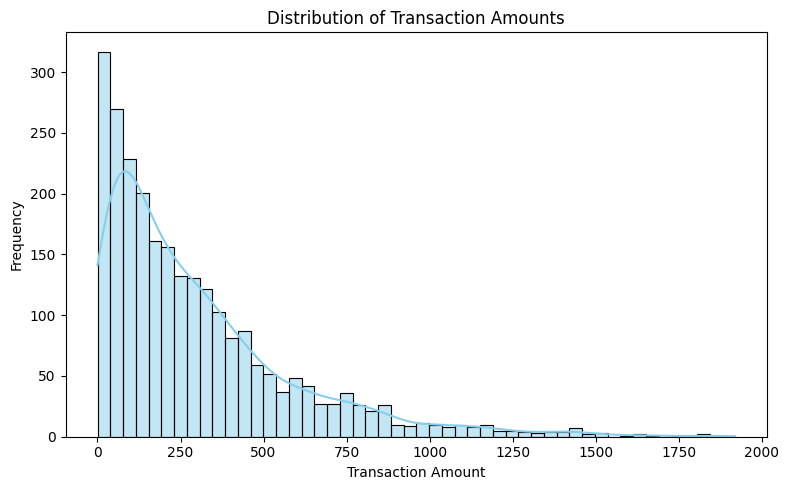

In [9]:

# Transaction Amount Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['TransactionAmount'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


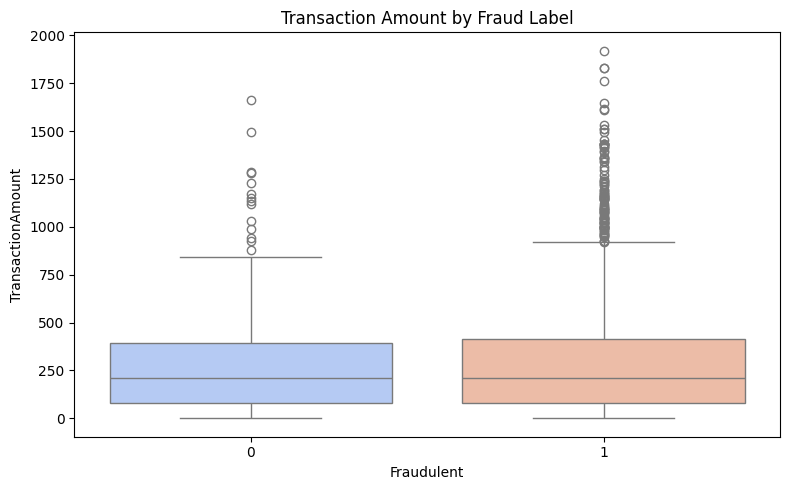

In [10]:

# Boxplot of Transaction Amount by Fraudulent Label
plt.figure(figsize=(8, 5))
sns.boxplot(x='Fraudulent', y='TransactionAmount', data=data, palette='coolwarm')
plt.title('Transaction Amount by Fraud Label')
plt.tight_layout()
plt.show()


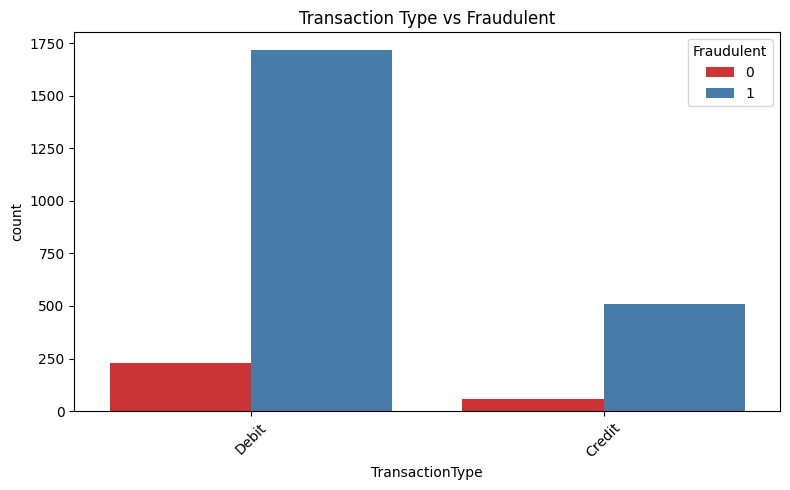

In [11]:

# Bar plot of Transaction Type
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='TransactionType', hue='Fraudulent', palette='Set1')
plt.title('Transaction Type vs Fraudulent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


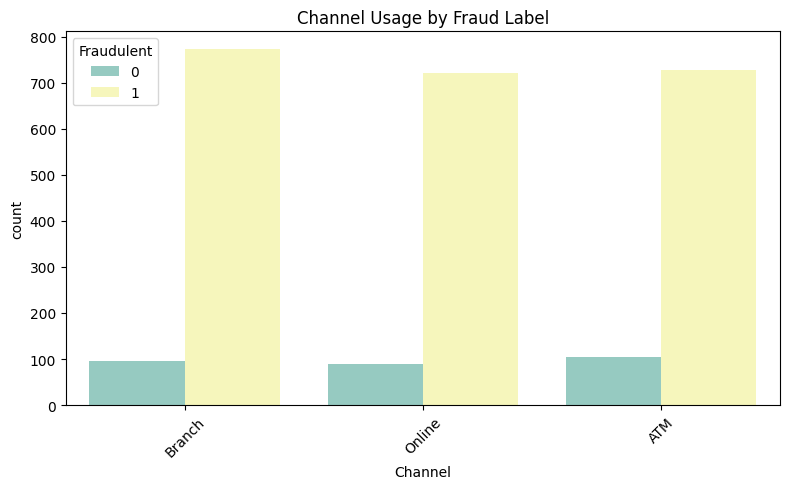

In [12]:

# Bar plot of Channel used
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Channel', hue='Fraudulent', palette='Set3')
plt.title('Channel Usage by Fraud Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

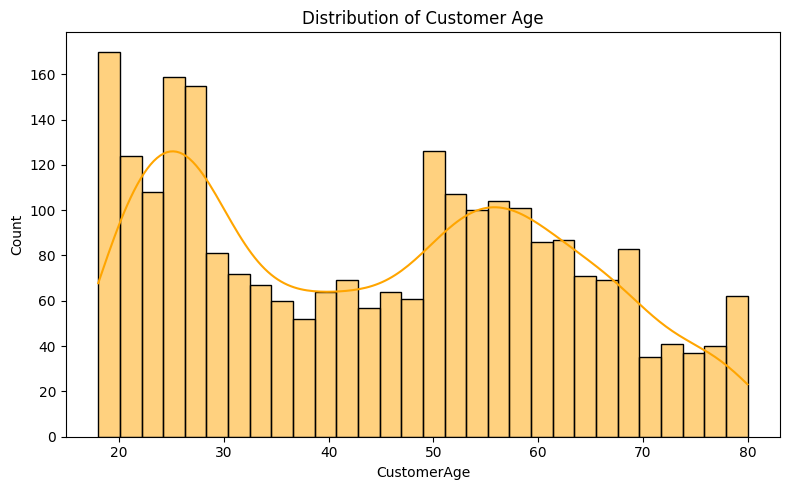

In [13]:

# Age distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['CustomerAge'], bins=30, kde=True, color='orange')
plt.title('Distribution of Customer Age')
plt.tight_layout()
plt.show()


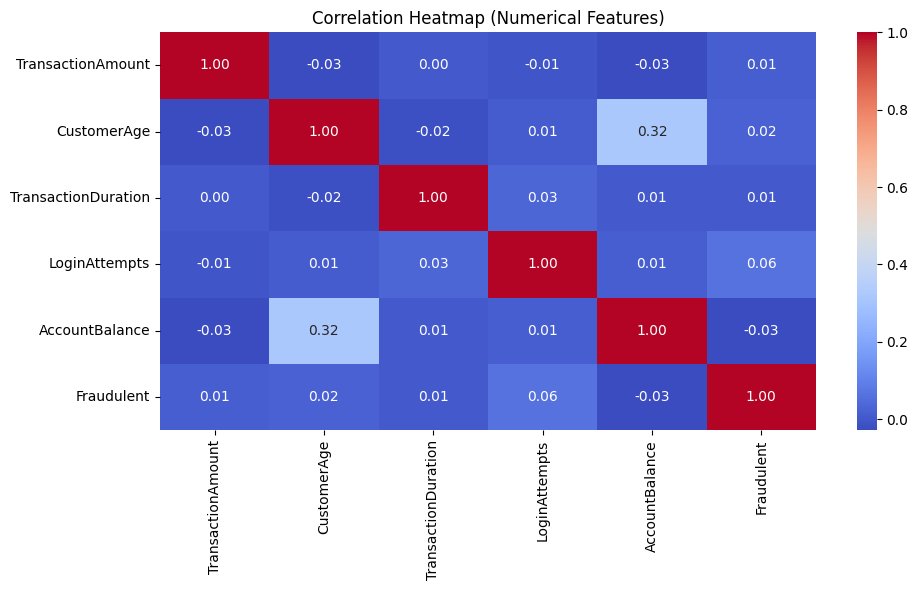

In [ ]:
#Correlation Analysis
plt.figure(figsize=(10, 6))
corr = data.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Numerical Features)')
plt.tight_layout()
plt.show()


In [ ]:
#DATA PREPROCESSING
# Drop irrelevant columns
data.drop(['TransactionID', 'AccountID', 'PreviousTransactionDate', 'TransactionDate'], axis=1, inplace=True)



In [ ]:
#Filter high-value transactions
threshold = data["TransactionAmount"].mean()
print(f"Threshold (Mean Transaction Amount): {threshold}")
high_value_data = data[data["TransactionAmount"] > threshold].copy()


Threshold (Mean Transaction Amount): 297.5937778662421


In [17]:

# Encode categorical columns
categorical_cols = high_value_data.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    high_value_data[col] = LabelEncoder().fit_transform(high_value_data[col])


In [18]:

y = high_value_data['Fraudulent']
X = high_value_data.drop(columns=['Fraudulent'])

# Before SMOTE
print("Class distribution before SMOTE:")
print(y.value_counts())


Class distribution before SMOTE:
Fraudulent
1    843
0    109
Name: count, dtype: int64


In [19]:

# Balance dataset using SMOTE
X_resampled, y_resampled = SMOTE(random_state=seed).fit_resample(X, y)


# After SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())



Class distribution after SMOTE:
Fraudulent
1    843
0    843
Name: count, dtype: int64


In [20]:

# Feature selection using chi-squared test
k_features = min(12, X.shape[1])
selector = SelectKBest(score_func=chi2, k=k_features)
X_selected = selector.fit_transform(X_resampled, y_resampled)
selected_columns = X.columns[selector.get_support()]

print("selected features:",selected_columns)
X_selected_df = pd.DataFrame(X_selected, columns=selected_columns)
X_selected_df.head()


selected features: Index(['TransactionAmount', 'TransactionType', 'Location', 'DeviceID',
       'IP Address', 'MerchantID', 'Channel', 'CustomerAge',
       'CustomerOccupation', 'TransactionDuration', 'LoginAttempts',
       'AccountBalance'],
      dtype='object')


TransactionAmount  TransactionType  Location  DeviceID  IP Address  \
0             476.99              1.0      36.0     448.0        37.0   
1             395.16              1.0      25.0     206.0       155.0   
2             331.66              1.0      19.0      32.0         0.0   
3             516.47              0.0       5.0     326.0       385.0   
4             416.62              0.0       3.0     383.0       144.0   

   MerchantID  Channel  CustomerAge  CustomerOccupation  TransactionDuration  \
0        21.0      2.0         23.0                 3.0                187.0   
1        58.0      2.0         56.0                 2.0                 17.0   
2        39.0      0.0         76.0                 2.0                145.0   
3        25.0      0.0         25.0                 3.0                 94.0   
4        90.0      2.0         26.0                 3.0                 67.0   

   LoginAttempts  AccountBalance  
0            1.0         1154.48  
1            1.0         5340.73  
2            1.0         7216.30  
3            1.0         1305.06  
4            1.0         9700.90

epoch 0  | loss: 6.00208 | test_accuracy: 0.50592 | test_auc: 0.523   |  0:00:00s
epoch 1  | loss: 1.71236 | test_accuracy: 0.50592 | test_auc: 0.49576 |  0:00:01s
epoch 2  | loss: 1.57437 | test_accuracy: 0.49704 | test_auc: 0.46614 |  0:00:02s
epoch 3  | loss: 1.13338 | test_accuracy: 0.50888 | test_auc: 0.51517 |  0:00:03s
epoch 4  | loss: 1.00549 | test_accuracy: 0.51775 | test_auc: 0.54064 |  0:00:03s
epoch 5  | loss: 0.86932 | test_accuracy: 0.5     | test_auc: 0.50403 |  0:00:04s
epoch 6  | loss: 0.80543 | test_accuracy: 0.53846 | test_auc: 0.56036 |  0:00:04s
epoch 7  | loss: 0.74397 | test_accuracy: 0.53846 | test_auc: 0.52636 |  0:00:05s
epoch 8  | loss: 0.72648 | test_accuracy: 0.49704 | test_auc: 0.48655 |  0:00:06s
epoch 9  | loss: 0.72218 | test_accuracy: 0.47929 | test_auc: 0.47402 |  0:00:07s
epoch 10 | loss: 0.6585  | test_accuracy: 0.49112 | test_auc: 0.44931 |  0:00:08s
epoch 11 | loss: 0.66413 | test_accuracy: 0.52959 | test_auc: 0.46703 |  0:00:08s
epoch 12 | loss:

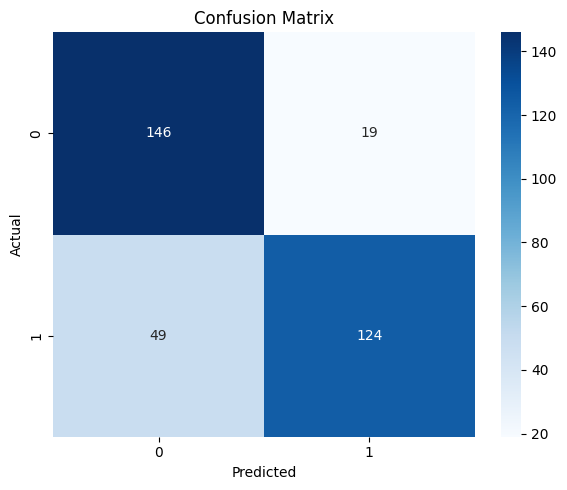

Successfully saved model at tabnet_fraud_detection_model.zip


'tabnet_fraud_detection_model.zip'

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected_df, y_resampled, test_size=0.2, random_state=seed)

# Convert to numpy arrays
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

# Initialize TabNet Classifier without early stopping
clf = TabNetClassifier(
    n_d=64,
    n_a=64,
    n_steps=7,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),
    mask_type='entmax',
    scheduler_params={"step_size": 10, "gamma": 0.95},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1,
    seed=seed
)

# Train model (no early stopping)
clf.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_name=['test'],
    eval_metric=['accuracy', 'auc'],
    max_epochs=1000,
    patience=0,  
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Make predictions
y_pred = clf.predict(X_test_np)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



#Save the Model
clf.save_model("tabnet_fraud_detection_model1")



PermutationExplainer explainer: 339it [37:44,  6.70s/it]                         


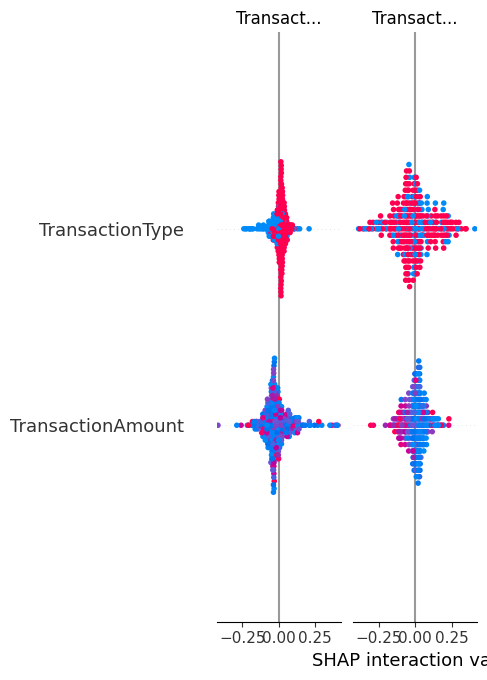

In [ ]:
#SHAP Analysis
import shap

clf = TabNetClassifier()
clf.load_model("tabnet_fraud_detection_model.zip")


clf.network.eval()


explainer = shap.Explainer(clf.predict_proba, X_test_np)


shap_values = explainer(X_test_np)


shap.summary_plot(shap_values.values, X_test, feature_names=selected_columns)

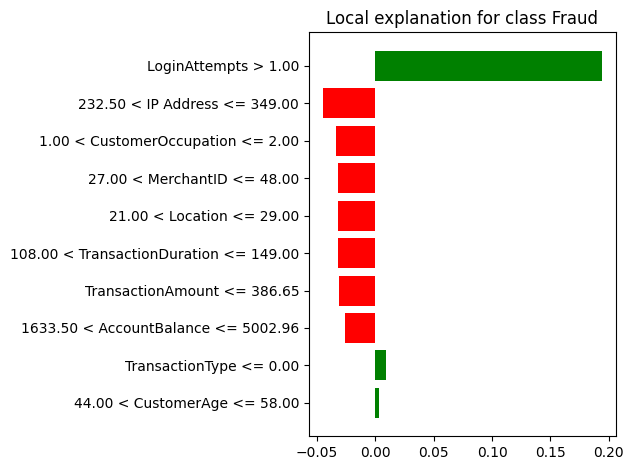

In [ ]:
#LIME Analysis
#!pip install lime
import lime
import lime.lime_tabular

clf.network.eval()

# %%
# Setup LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=selected_columns,
    class_names=["Not Fraud", "Fraud"],
    mode='classification',
    discretize_continuous=True
)

idx = 0
exp = explainer.explain_instance(
    data_row=X_test_np[idx],
    predict_fn=clf.predict_proba
)

# Show explanation
exp.show_in_notebook(show_table=True, show_all=False)

# Or plot explanation
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()